# Embeddings to test

* UMAP
* t-SNE
* Parametric UMAP (part of UMAP)
* DenseMap (part of UMAP)
* [PacMap](https://github.com/YingfanWang/PaCMAP)
* [TriMap](https://github.com/eamid/trimap)
* PCA
* Laplacian eigenmaps
* MDS
* Isomap
* [MDE](https://github.com/cvxgrp/pymde)
* [PHATE](https://github.com/KrishnaswamyLab/PHATE)
* ForceAtlas2
* dbMAP


# Experiments

* distance/distance-rank preservation with varying ```n_neighbors```, ```n_components``` and ```min_dist```, measured with Pearson's corr.
* hierarchical embedding: original -> 1000d -> 100d -> 2d
* negative test: does it magically create clusters? Test using a high dimensional Gaussian


Metrics:
* Spearman rank correlation between samples
* Pearson correlation of distances
* Distance correlation of distances
* Average Jaccard distance


In [9]:
%load_ext autoreload
%autoreload 1
#%aimport omic_helpers
%matplotlib inline

#from omic_helpers import graph_clustering
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler, MinMaxScaler, FunctionTransformer
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

import umap
import pacmap
import trimap
import pymde
import dbmap

import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, KernelPCA, NMF, FactorAnalysis
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness

from tqdm import tqdm

from scipy.sparse import csr_matrix

import gc

sys.path.append( '../')
from embedders import embedding


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def get_intra_sample_distances(X, how='euclidean'):
    if how == 'euclidean':  
        return distance.pdist(X)

In [11]:
# [x] Sammon mapping: https://arxiv.org/pdf/2009.08136.pdf
# [x] landmark maximum variance unfolding 
# [x] Landmark MDS
# [x] GSOM: https://github.com/CDAC-lab/pygsom/tree/master/gsom -> never mind this is a clustering method..
# [x] SMACOF

# IVIS: https://github.com/beringresearch/ivis, https://www.nature.com/articles/s41598-019-45301-0
# RankVisu
# diffeomorphic dimensionality reduction Diffeomap
# FastMap MDS: https://github.com/shawn-davis/FastMapy
# FactorizedEmbeddings: https://github.com/TrofimovAssya/FactorizedEmbeddings, https://academic.oup.com/bioinformatics/article/36/Supplement_1/i417/5870511
# MetricMap
# SparseMap: https://github.com/vene/sparsemap
# growing curvilinear component analysis
# curvilinear distance analysis
# autoencoder NeuroScale
# PHATE
# GPLVM
# FA
# Nonlinear PCA
# SDNE 
# GCN
# Graph Factorisation
# HOPE
# opt-SNE: https://github.com/omiq-ai/Multicore-opt-SNE
#  Poincare embedding : https://github.com/facebookresearch/poincare-embeddings
# NN-graph/Parametric UMAP -> GraphSage/Node2Vec/etc.. see NetworkX and karateclub!
# https://github.com/benedekrozemberczki/karateclub
# https://github.com/palash1992/GEM-Benchmark, https://github.com/palash1992/GEM

# https://www.sciencedirect.com/science/article/pii/S0950705118301540

In [12]:
def generate_2d_test_sets(**kwargs):
    
    transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
    
    sets = []
    mcluster = datasets.make_blobs(n_samples=1000, n_features=3, centers=[(-10,-10), (10,10), (-10,10), (10,-10)], 
                                cluster_std=[1., 0.5, 1.5, 0.75])[0]
    mcluster = StandardScaler().fit_transform(mcluster)
    sets.append(mcluster)
    #####################
    mcluster = datasets.make_circles(n_samples=1000, factor=.4, noise=.01)[0]
    mcluster = StandardScaler().fit_transform(mcluster)
    sets.append(mcluster)
    #####################
    mcluster = datasets.make_s_curve(n_samples=1000, noise=.2)[0]
    mcluster = StandardScaler().fit_transform(mcluster)[:,[0,2]]    
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    #####################
    mcluster = datasets.make_moons(n_samples=1000, noise=.1)[0]
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    sets.append(mcluster)
    #####################
    mcluster = datasets.make_blobs(n_samples=1000, centers=3, cluster_std=[1., 0.5, 1.5])[0]
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    sets.append(mcluster)
    #####################
    mcluster = datasets.make_blobs(n_samples=1000, centers=4, cluster_std=[1., 0.5, 1.5, 0.75])[0]
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    #####################
    x = np.random.lognormal(mean=0., sigma=0.25, size=1000)
    y = -0.3/x**3 + np.random.normal(loc=0., scale=0.1, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])

    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    #####################
    x = np.random.lognormal(mean=0., sigma=0.25, size=1000)
    y = 2*x**2 + np.random.normal(loc=0., scale=0.1, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])

    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    #####################
    x = np.random.normal(loc=0, scale=0.5, size=1000)
    y = 2*x**2 + np.random.uniform(low=-0.5, high=0.5, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])

    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    sets.append(mcluster)
    #####################
    x = np.random.normal(loc=0, scale=0.5, size=1000)
    y = -2*x**2 + np.random.uniform(low=-0.5, high=0.5, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])

    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    sets.append(mcluster)
    #####################
    x = np.random.normal(loc=0.1, scale=0.5, size=1000)
    y = 2*x**2 + np.random.uniform(low=-0.5, high=0.5, size=1000)
    mcluster1 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster1 = StandardScaler().fit_transform(mcluster1)[:,:]

    x = np.random.normal(loc=-0.1, scale=0.5, size=1000)
    y = -2*x**2 + np.random.uniform(low=-0.5, high=0.5, size=1000)
    mcluster2 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster2 = StandardScaler().fit_transform(mcluster2)[:,:]
    mcluster = np.vstack([mcluster1, mcluster2])
    sets.append(mcluster)
    ####################
    x = np.random.normal(loc=0.1, scale=0.4, size=1000)
    y = np.sin(4*x) + np.random.uniform(low=-0.2, high=0.2, size=1000)
    mcluster1 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster1 = StandardScaler().fit_transform(mcluster1)[:,:]

    x = np.random.normal(loc=-0.1, scale=0.4, size=1000)
    y = np.sin(4*x) + np.random.uniform(low=-0.2, high=0.2, size=1000)
    mcluster2 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster2 = StandardScaler().fit_transform(mcluster2)[:,:]
    mcluster = np.vstack([mcluster1, mcluster2])
    sets.append(mcluster)
    ####################
    x = np.random.normal(loc=0.1, scale=0.4, size=1000)
    y = -np.sin(4*x) + np.random.uniform(low=-0.3, high=0.3, size=1000)
    mcluster1 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster1 = StandardScaler().fit_transform(mcluster1)[:,:]

    x = np.random.normal(loc=-0.1, scale=0.4, size=1000)
    y = np.sin(4*x) + np.random.uniform(low=-0.3, high=0.3, size=1000)
    mcluster2 = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster2 = StandardScaler().fit_transform(mcluster2)[:,:]

    mcluster = np.vstack([mcluster1, mcluster2])
    sets.append(mcluster)
    ###################
    x = np.random.normal(loc=0.0, scale=0.5, size=1000)
    y = x*np.sin(8*x+1) + np.random.uniform(low=-0.4, high=0.4, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)    
    ###################
    x = np.random.normal(loc=0.0, scale=0.5, size=1000)
    y = np.random.normal(loc=0.0, scale=0.5, size=1000) # np.random.uniform(low=-0.4, high=0.4, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    sets.append(mcluster)
    ###################
    transformation = [[0.95, -0.33667341], [-0.30887718, 0.95]]
    x = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    y = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    ###################
    transformation = [[0.95, 0.33667341], [0.30887718, 0.95]]
    x = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    y = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]
    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    ###################
    transformation = [[0.7071, -0.7071], [0.7071, 0.7071]]

    x = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    y = np.random.uniform(low=-0.4, high=0.4, size=1000) # np.random.normal(loc=0.0, scale=0.5, size=1000)
    mcluster = np.hstack([x.reshape(-1,1), y.reshape(-1,1)])
    mcluster = StandardScaler().fit_transform(mcluster)[:,:]

    mcluster = np.dot(mcluster[:,[0,1]], transformation)
    sets.append(mcluster)
    
    return sets, kwargs



## Local correlations

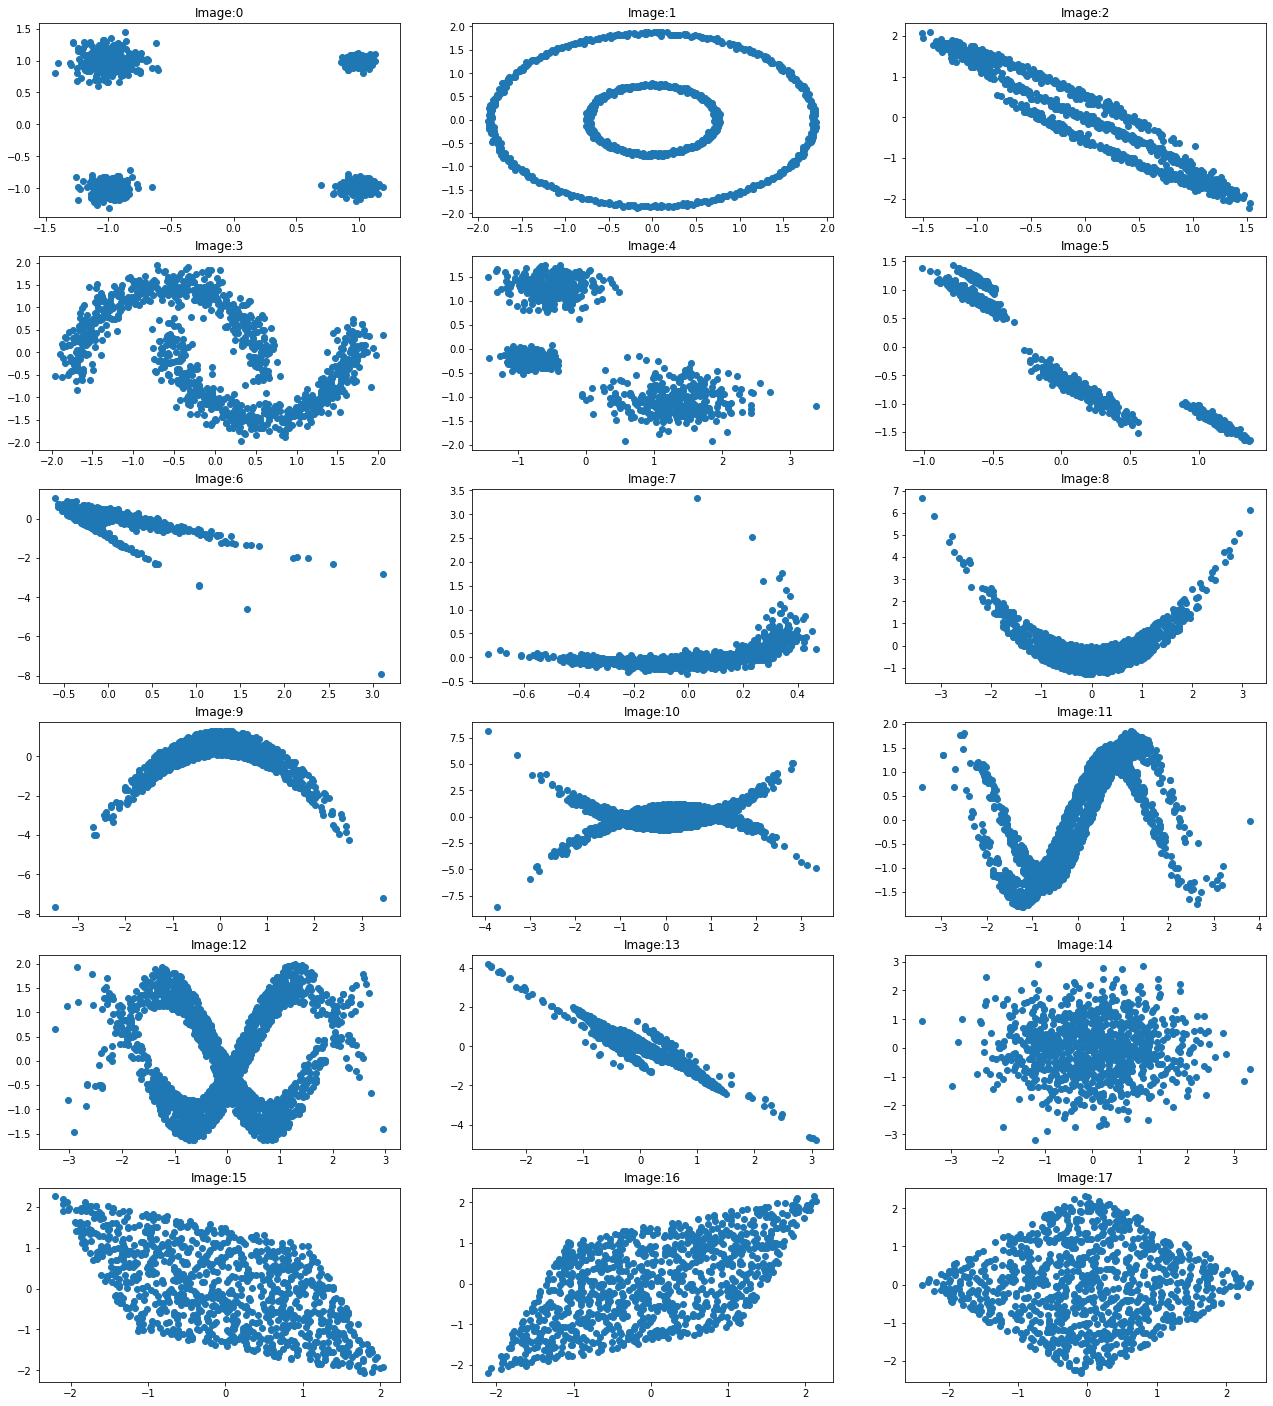

In [13]:
test_sets = generate_2d_test_sets()[0]
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(22,25))
for k, ds in enumerate(test_sets):
    j=k%3 
    i=int(k/3)
    ax[i,j].scatter(x=ds[:,0], y=ds[:,1])
    ax[i,j].set_title(f'Image:{k}')

In [ ]:
#spread_factor = 0.1
#dimensions = 2
#ts = 4
#gsom_test = graph_clustering.GSOM(spread_factor,
#                                  dimensions,
#                                  smooth_iterations=100,
#                                  training_iterations=250,
#                                  learning_rate=.1)
#gsom_test.fit(test_sets[ts])
#assignments = gsom_test.train_assignments- gsom_test.train_assignments.min()

#plot_df = pd.DataFrame(data=test_sets[ts], columns=['d1', 'd2'])
#plot_df['cluster'] = assignments.astype(str)
#sns.scatterplot(data=plot_df, x='d1', y='d2', hue='cluster', alpha=0.5)
#print(plot_df.cluster.nunique())

In [14]:
embedder_type = 'Sammon'

n_n = 7

embedder = {}
embedder['umap'] = umap.UMAP(n_components=2, densmap=True, metric='l2', n_neighbors=n_n, min_dist=0.)
embedder['trimap'] = trimap.TRIMAP(n_dims=2, n_iters=750)
embedder['pacmap'] = pacmap.PaCMAP(n_dims=2, n_neighbors=n_n)
embedder['SpectralEmbedding'] = SpectralEmbedding(n_components=2, n_neighbors=n_n)
embedder['Isomap'] = Isomap(n_components=2)
embedder['MDS'] = MDS(n_components=2)
embedder['KernelPCA'] = KernelPCA(n_components=2)
embedder['PCA'] = PCA(n_components=2)
embedder['dbmap'] = dbmap.diffusion.Diffusor(n_components=120, ann_dist='euclidean')
embedder['LLE'] = LLE(n_components=2, n_neighbors=n_n, method='hessian') # ltsa
embedder['NMF'] = NMF(n_components=2, max_iter=2000) 
embedder['Sammon'] = embedding.Sammon(n_components=2, n_neighbors=n_n,
                                            max_iterations=250, learning_rate=0.1, init_type='PCA')
embedder['MVU'] = embedding.MaximumVarianceUnfolding(n_components=2, n_neighbors=n_n)
embedder['LMVU'] = embedding.LandmarkMaximumVarianceUnfolding(n_components=2, n_landmarks=50,
                                                                     n_neighbors=n_n)

test_sets_embedded = []
if embedder_type == 'dbmap':
    for ts in tqdm(test_sets):
        tts = embedder['dbmap'].fit_transform(ts)
        test_sets_embedded.append(np.array(embedder['umap'].fit_transform(tts)))
elif embedder_type == 'NMF':
    for ts in tqdm(test_sets):
        tts = ts + np.abs(np.min(ts, axis=0))
        test_sets_embedded.append(np.array(embedder['NMF'].fit_transform(tts)))    
else:
    for ts in tqdm(test_sets):
        test_sets_embedded.append(np.array(embedder[embedder_type].fit_transform(ts)))

  6%|▌         | 1/18 [00:00<00:03,  5.07it/s]

Performing quasi Newton, iteration 0
Performing quasi Newton, iteration 0


 17%|█▋        | 3/18 [00:00<00:02,  5.47it/s]

Performing quasi Newton, iteration 0
Performing quasi Newton, iteration 0


 28%|██▊       | 5/18 [00:00<00:02,  5.53it/s]

Performing quasi Newton, iteration 0
Performing quasi Newton, iteration 0


 39%|███▉      | 7/18 [00:01<00:01,  5.51it/s]

Performing quasi Newton, iteration 0
Performing quasi Newton, iteration 0


 50%|█████     | 9/18 [00:01<00:01,  5.52it/s]

Performing quasi Newton, iteration 0
Performing quasi Newton, iteration 0


 56%|█████▌    | 10/18 [00:01<00:01,  5.53it/s]

Performing quasi Newton, iteration 0


 61%|██████    | 11/18 [00:02<00:02,  3.30it/s]

Performing quasi Newton, iteration 0


 67%|██████▋   | 12/18 [00:02<00:02,  2.62it/s]

Performing quasi Newton, iteration 0


 78%|███████▊  | 14/18 [00:03<00:01,  2.82it/s]

Performing quasi Newton, iteration 0
Performing quasi Newton, iteration 0


 89%|████████▉ | 16/18 [00:04<00:00,  3.76it/s]

Performing quasi Newton, iteration 0
Performing quasi Newton, iteration 0


100%|██████████| 18/18 [00:04<00:00,  4.07it/s]

Performing quasi Newton, iteration 0


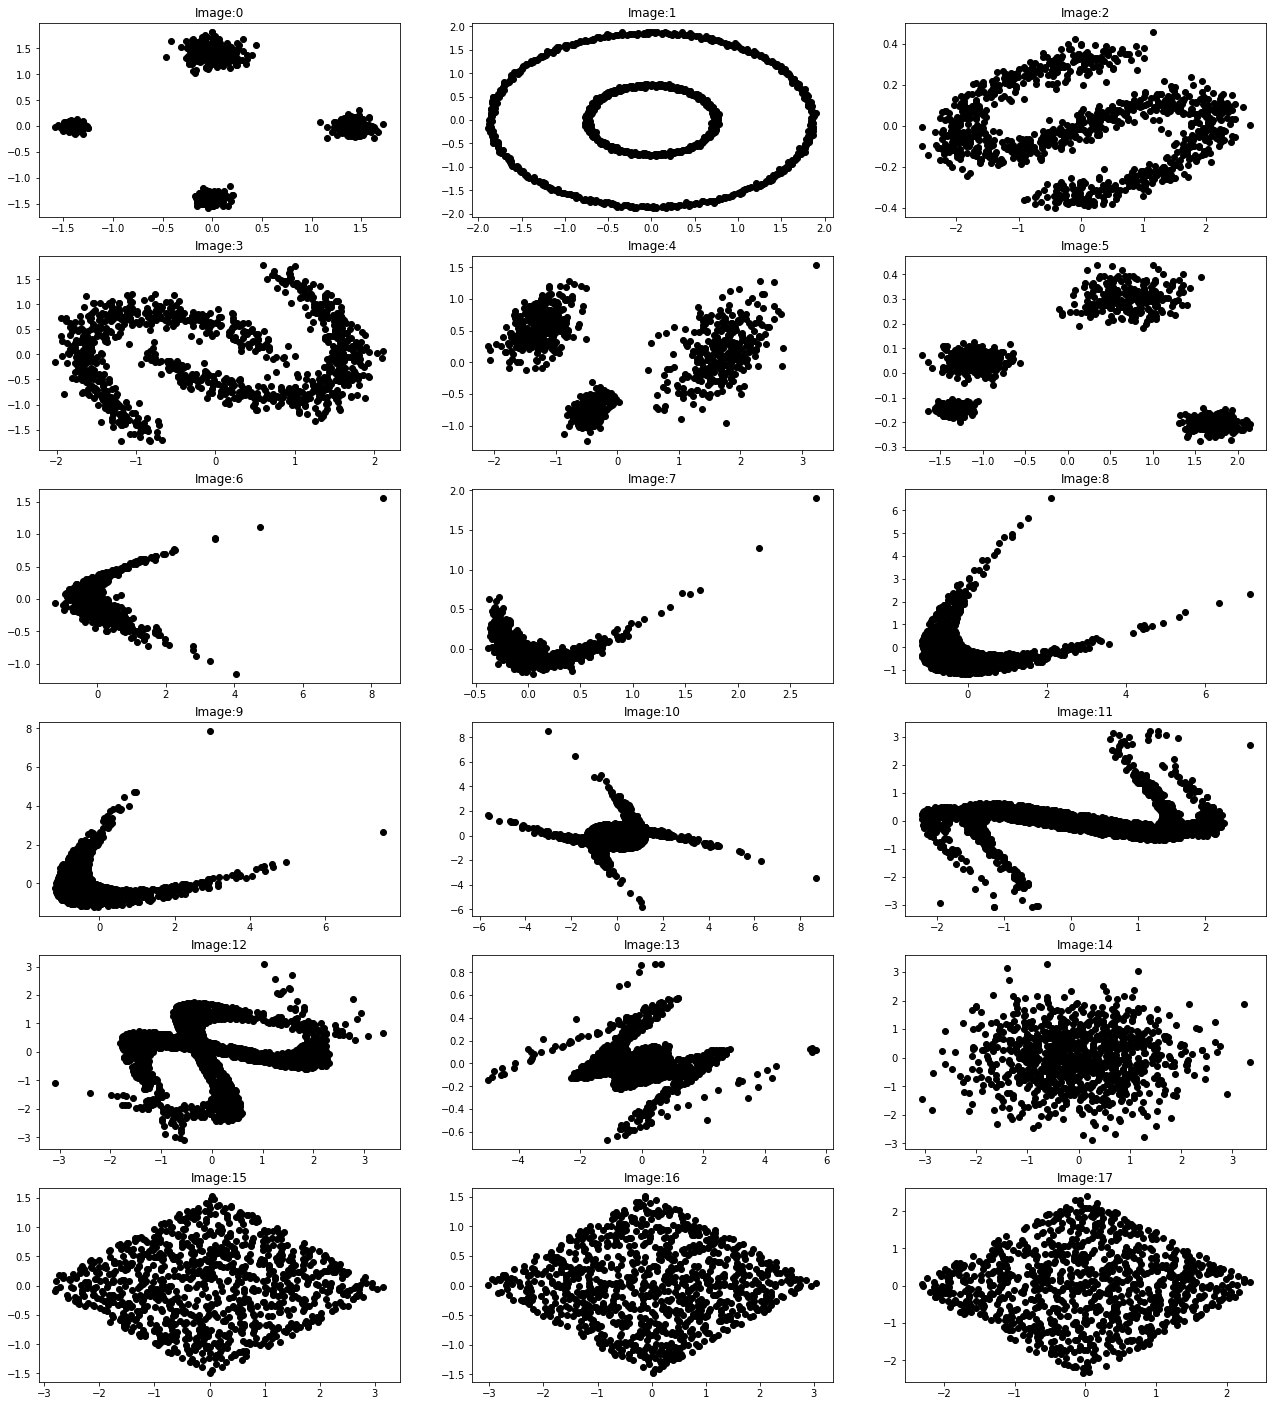

In [15]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(22,25))
for k, ds in enumerate(test_sets_embedded):
    j=k%3 
    i=int(k/3)
    ax[i,j].scatter(x=ds[:,0], y=ds[:,1], color='black')
    ax[i,j].set_title(f'Image:{k}')

In [16]:
num_samples = 1000
sample_size = 100

dist_preservation = []
dists = []
for num in tqdm(range(0,18)):
    sample_selection = np.random.randint(0,num_samples, sample_size)
    dist_or = get_intra_sample_distances(test_sets[num][sample_selection,:])
    dist_emb = get_intra_sample_distances(test_sets_embedded[num][sample_selection,:])

    dists.append({'d_or': dist_or, 'd_emb': dist_emb})
    dist_preservation.append({'dataset': num , 'corr':spearmanr(dist_or, dist_emb)[0]})

100%|██████████| 18/18 [00:00<00:00, 459.36it/s]


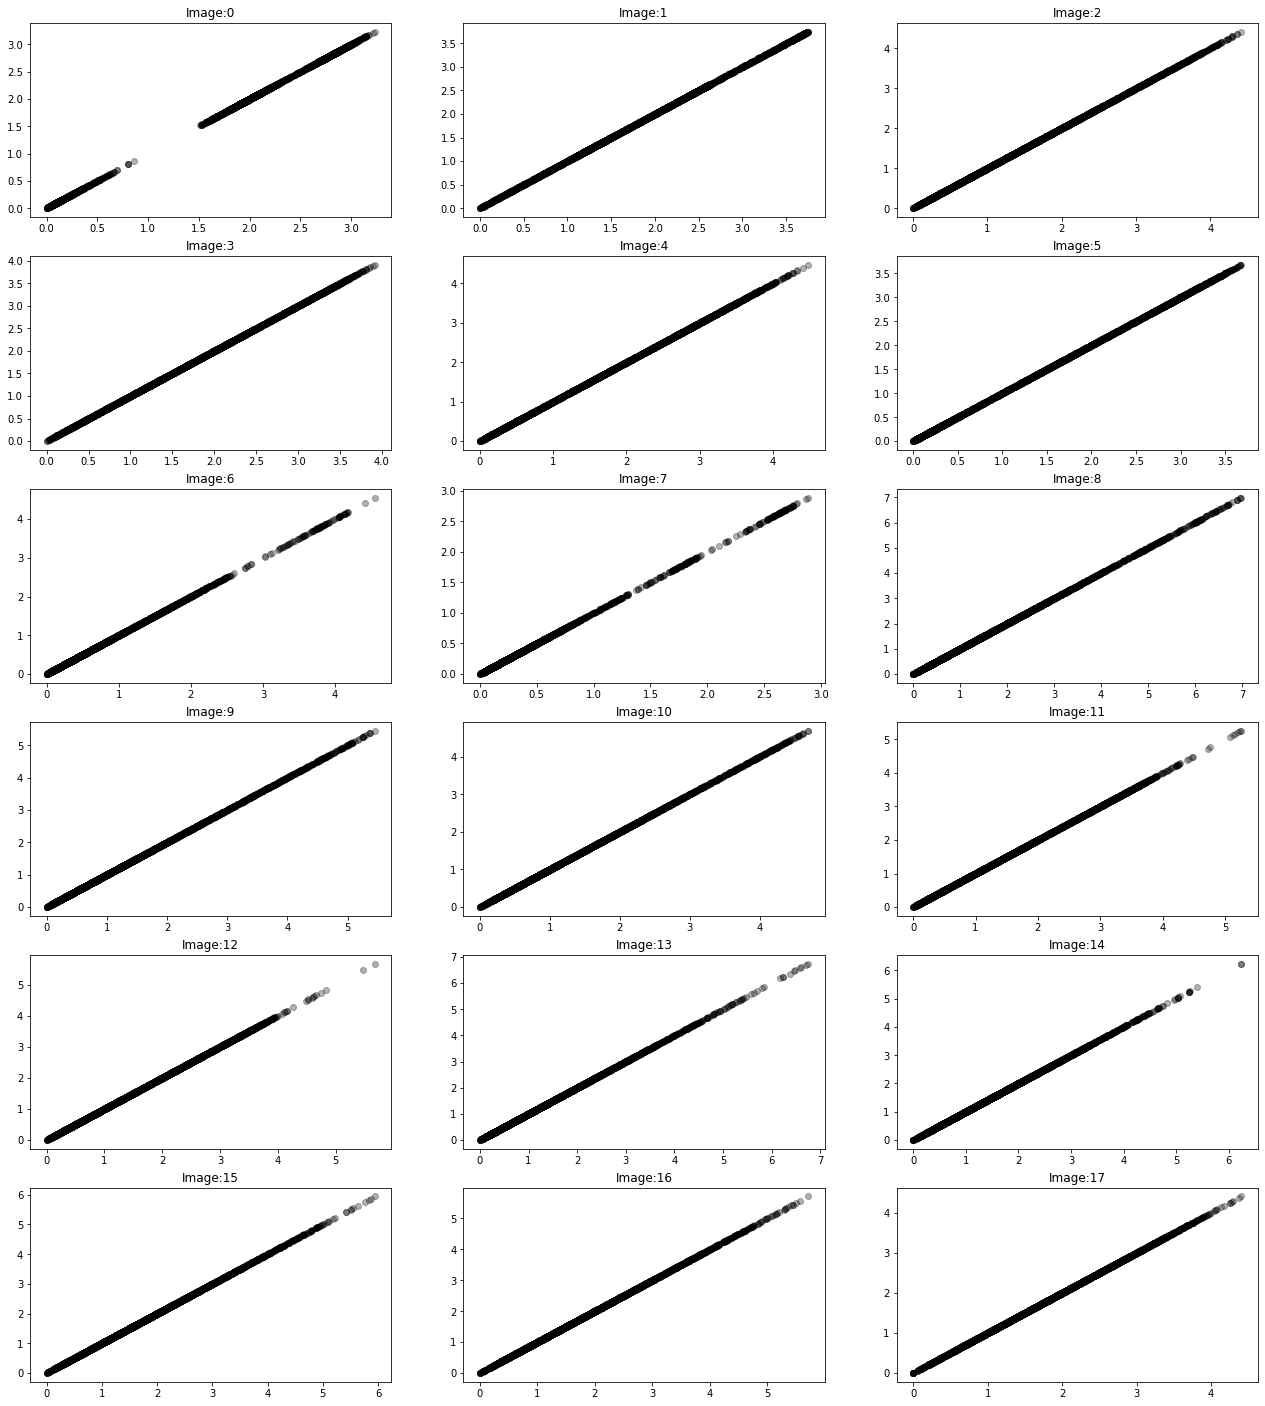

In [17]:
fig, ax = plt.subplots(ncols=3, nrows=6, figsize=(22,25))
for k, ds in enumerate(dists):
    j=k%3 
    i=int(k/3)
    ax[i,j].scatter(x=ds['d_or'], y=ds['d_emb'], color='black', alpha=0.3)
    ax[i,j].set_title(f'Image:{k}')